# Exploring sea ice heights with ICESat-2 (ATL07)

Information obtained primarily from the ATL07/10 Algorithm Theoretical Basis Document (ATBD, Kwok et al., 2019, see link below) and the NSIDC product description page: https://nsidc.org/data/atl07.   

* Notebook author: Alek Petty, relying extensively on above product manuals.    
* Description: Notebook describing the ICESat-2 ATL07 product.   
* Input requirements: Demo ATL07 data file   
* Date: June 2019
* More info: See the ATL07/ATL10 Algorithm Theoretical Basis Document (ATBD): https://icesat-2.gsfc.nasa.gov/sites/default/files/page_files/ICESat2_ATL07_ATL10_ATBD_r001.pdf    and the known issues document: https://nsidc.org/sites/nsidc.org/files/technical-references/ATL0710-KnownIssues.pdf


## To do

* Add in function descriptions.
* Plot where this data is using Cartopy.
* Try and make sure this file is consistent with the ATL03 file. 


## Notebook objectives
* General understanding of the data included in a typical ATL07 file.
* Reading in, plotting and basic analysis of ATL07 data.
* How is ATL07 data used to generate ATL10 sea ice freeboards and what to look out for when using either product.


## Notebook instructions
1. Follow along with the notebook tutorial. 
2. Play around changing options and re-running the relevant notebook cells. 

Here I use the hdf5 file from: https://nsidc.org/data/atl07   
For the demo below I'm using the file: 'ATL07-01_20181115003141_07240101_001_01.h5'
If using this using the ICESAT-2 Pangeo instance, you can download the file using...


### Notes      
* Check out the known issues document: https://nsidc.org/sites/nsidc.org/files/technical-references/ATL0710-KnownIssues.pdf


In [130]:
#Magic function to enable interactive plotting in Jupyter notebook
#Allows you to zoom/pan within plots after generating
#Normally, this would be %matplotlib notebook, but since we're using Juptyerlab, we need a different widget
#%matplotlib notebook
%matplotlib inline

In [131]:
#Import necesary modules
#Use shorter names (np, pd, plt) instead of full (numpy, pandas, matplotlib.pylot) for convenience
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import convert_GPS_time as cGPS
#import seaborn as sns
import pandas as pd
import h5py
import s3fs

# Use seasborn for nicer looking inline plots
#sns.set(context='notebook', style='darkgrid')
#st = axes_style("whitegrid")


In [132]:
# If file stored locally...
#file_path = '../Data/'
#ATL07_filename = 'ATL07-01_20181115003141_07240101_001_01.h5'
#localPath = file_path + ATL07_filename
beamStr='gt1r'

In [133]:
# If running on Pangeo instance and grabbing data from Amazon S3
bucket = 'pangeo-data-upload-oregon'
fs = s3fs.S3FileSystem()
dataDir = 'pangeo-data-upload-oregon/icesat2/'
s3List = fs.ls(dataDir)
print(s3List)
ATL07file='ATL07-01_20181115003141_07240101_001_01.h5'
s3File='pangeo-data-upload-oregon/icesat2/'+ATL07file
localPath='../Data/'+ATL07file
fs.get(s3File, localPath)

# Note how 

['pangeo-data-upload-oregon/icesat2/ATL03_20181115022655_07250104_001_01.h5', 'pangeo-data-upload-oregon/icesat2/ATL07-01_20181115003141_07240101_001_01.h5', 'pangeo-data-upload-oregon/icesat2/readme.txt', 'pangeo-data-upload-oregon/icesat2/Clouds_and_filtering_tutorial', 'pangeo-data-upload-oregon/icesat2/atl03', 'pangeo-data-upload-oregon/icesat2/atl06', 'pangeo-data-upload-oregon/icesat2/pine_island_glims']


In [134]:
# Python reader based on Pandas. Other reader examples available in readers.py

def getATL07data(fileT, numpy=0, beam='gt1r', maxElev=1e6):
    # Add in a proper description of the function here
    
    
    # Open the file
    ATL07 = h5py.File(fileT, 'r')
    
    lons=ATL07[beam+'/sea_ice_segments/longitude'][:]
    lats=ATL07[beam+'/sea_ice_segments/latitude'][:]
    
    # Along track distance from the equator crossing to the segment center. 
    # I removed the first point so it's relative to the start of the beam
    along_track_distance=ATL07[beam+'/sea_ice_segments/seg_dist_x'][:] - ATL07[beam+'/sea_ice_segments/seg_dist_x'][0]
    # Height segment ID (10 km segments)
    height_segment_id=ATL07[beam+'/sea_ice_segments/height_segment_id'][:] 
    #  Nathan says it's the number of seconds since the GPS epoch on midnight Jan. 6, 1980 
    delta_time=ATL07[beam+'/sea_ice_segments/delta_time'][:] 
    # #Add this value to delta time parameters to compute full gps_seconds
    atlas_epoch=ATL07['/ancillary_data/atlas_sdp_gps_epoch'][:] 

    # Conversion of delta_time to a calendar date
    temp = cGPS.convert_GPS_time(atlas_epoch[0] + delta_time, OFFSET=0.0)

    year = temp['year'][:].astype('int')
    month = temp['month'][:].astype('int')
    day = temp['day'][:].astype('int')
    hour = temp['hour'][:].astype('int')
    minute = temp['minute'][:].astype('int')
    second = temp['second'][:].astype('int')


    # Primary variables of interest
    
    # Beam segment height
    elev=ATL07[beam+'/sea_ice_segments/heights/height_segment_height'][:]
    # Flag for potential leads, 0=sea ice, 1 = sea surface
    ssh_flag=ATL07[beam+'/sea_ice_segments/heights/height_segment_ssh_flag'][:] 
    
    #Quality metrics for each segment include confidence level in the surface height estimate, which is based on the number of photons, the background noise rate, and the error measure provided by the surface-finding algorithm.
    # Height quality flag, 1 for good fit, 0 for bad
    quality=ATL07[beam+'/sea_ice_segments/heights/height_segment_quality'][:] 
    
    elev_rms = ATL07[beam+'/sea_ice_segments/heights/height_segment_rms'][:] #RMS difference between modeled and observed photon height distribution
    seg_length = ATL07[beam+'/sea_ice_segments/heights/height_segment_length_seg'][:] # Along track length of segment
    height_confidence = ATL07[beam+'/sea_ice_segments/heights/height_segment_confidence'][:] # Height segment confidence flag
    reflectance = ATL07[beam+'/sea_ice_segments/heights/height_segment_asr_calc'][:] # Apparent surface reflectance
    ssh_flag = ATL07[beam+'/sea_ice_segments/heights/height_segment_ssh_flag'][:] # Flag for potential leads, 0=sea ice, 1 = sea surface
    seg_type = ATL07[beam+'/sea_ice_segments/heights/height_segment_type'][:] # 0 = Cloud covered
    gauss_width = ATL07[beam+'/sea_ice_segments/heights/height_segment_w_gaussian'][:] # Width of Gaussian fit

    
    # Geophysical corrections
    # NOTE: All of these corrections except ocean tides, DAC, and geoid undulations are applied to the ATL03 photon heights.
    
    # AVISO dynamic Atmospheric Correction (DAC) including inverted barometer (IB) effect (±5cm)
    dac = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_dac'][:] 
    # Solid Earth Tides (±40 cm, max)
    earth = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_earth'][:]
    # Geoid (-105 to +90 m, max)
    geoid = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_geoid'][:] 
    # Local displacement due to Ocean Loading (-6 to 0 cm)
    loadTide = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_load'][:] 
    # Ocean Tides including diurnal and semi-diurnal (harmonic analysis), 
    # and longer period tides (dynamic and self-consistent equilibrium) (±5 m)
    oceanTide = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_ocean'][:]
    # Deformation due to centrifugal effect from small variations in polar motion 
    # (Solid Earth Pole Tide) (±1.5 cm, the ocean pole tide ±2mm amplitude is considered negligible)
    poleTide = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_pole'][:] 
    # Mean sea surface (±2 m)
    # Taken from ICESat and CryoSat-2, see Kwok and Morison [2015])
    mss = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_mss'][:]
    
    photon_rate = ATL07[beam+'/sea_ice_segments/stats/photon_rate'][:]
    
    ATL07.close()
    
    
    if (numpy==1):
        # list the variables you want to output here..
        return along_track_dist, elev
    
    else:
        dF = pd.DataFrame({'elev':elev, 'lons':lons, 'lats':lats, 'ssh_flag':ssh_flag, 
                       'quality_flag':quality, 'delta_time':delta_time,'along_track_distance':along_track_distance, 'height_segment_id':height_segment_id, 'photon_rate':photon_rate, 'year':year, 'month':month, 'day':day, 'hour':hour, 'second':second})
        
        # Filter out high elevation values 
        dF = dF[(dF['elev']<maxElev)]
        # Reset row indexing
        dF=dF.reset_index(drop=True)
        return dF


In [135]:
# Get data using numpy
#along_track_dist, elev=getATL07data(ATL07_file_path, numpy=1, beam=beamStr)
#good = np.where((elev < 100) )	#& (quality_1l == 1)
#along_track_dist=along_track_dist[good]
#elev=elev[good]
#plt.figure(figsize=(10, 5))
#plt.plot((along_track_dist-along_track_dist[0])/1000., elev)
#plt.xlabel('Along track distance (km)')
#plt.ylabel('Elevation (m)')
#plt.show()

# Get data using Pandas
dF07=getATL07data(localPath, beam=beamStr)
dF07.head(10)


,elev,lons,lats,ssh_flag,quality_flag,delta_time,along_track_distance,height_segment_id,photon_rate,year,month,day,hour,second
0,0.443309,-164.275288,59.864463,0,1,2.747804e+07,0.000000,7,1.158333,2018,11,15,0,18
1,0.439604,-164.275288,59.864463,0,1,2.747804e+07,0.000000,8,2.278688,2018,11,15,0,18
2,0.469707,-164.275327,59.864671,0,1,2.747804e+07,23.241180,9,2.089552,2018,11,15,0,18
3,0.422271,-164.275374,59.864914,0,1,2.747804e+07,50.413780,10,1.769231,2018,11,15,0,18
4,0.392907,-164.275425,59.865173,1,1,2.747804e+07,79.494333,11,1.833333,2018,11,15,0,18
5,0.463985,-164.275467,59.865382,0,1,2.747804e+07,102.866701,12,1.792208,2018,11,15,0,18
6,0.459417,-164.275525,59.865664,0,1,2.747804e+07,134.467971,13,1.626506,2018,11,15,0,18
7,0.406700,-164.275581,59.865928,1,1,2.747804e+07,163.985996,14,1.759494,2018,11,15,0,18
8,0.423204,-164.275631,59.866162,0,1,2.747804e+07,190.218132,15,1.625000,2018,11,15,0,18
9,0.486481,-164.275704,59.866502,0,1,2.747804e+07,229.907124,16,1.500000,2018,11,15,0,18


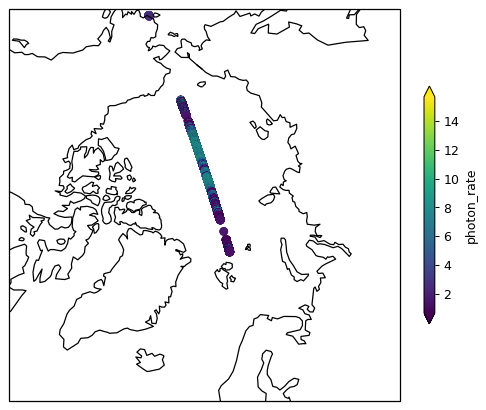

In [195]:
# Map the data for visual inspection usign Cartopy
var='photon_rate'
dF07.along_track_distance
plt.figure(figsize=(7,7), dpi= 90)
# Make a new projection "NorthPolarStereo"
ax = plt.axes(projection=ccrs.NorthPolarStereo(true_scale_latitude=70))
plt.scatter(dF07['lons'], dF07['lats'],c=dF07[var], cmap='viridis', transform=ccrs.PlateCarree())
#plt.pcolormesh(lons, lats, tile_to_plot,
#               transform=ccrs.PlateCarree());

ax.coastlines()
#ax.drawmeridians()
plt.colorbar(label=var, shrink=0.5, extend='both')

# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())

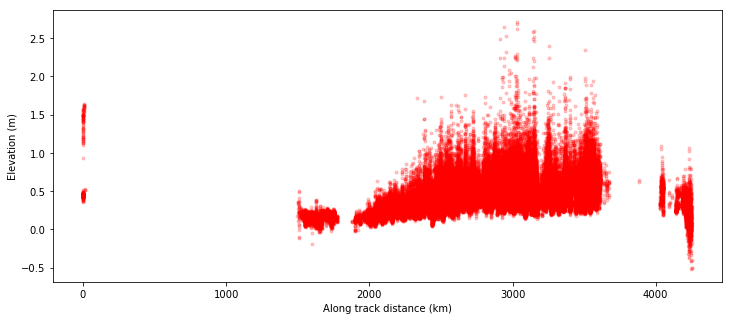

In [136]:
plt.figure(figsize=(12, 5))
plt.plot((dF07.along_track_distance)/1000., dF07.elev, color='r', marker='.', linestyle='None', alpha=0.2)
plt.xlabel('Along track distance (km)')
plt.ylabel('Elevation (m)')
plt.show()


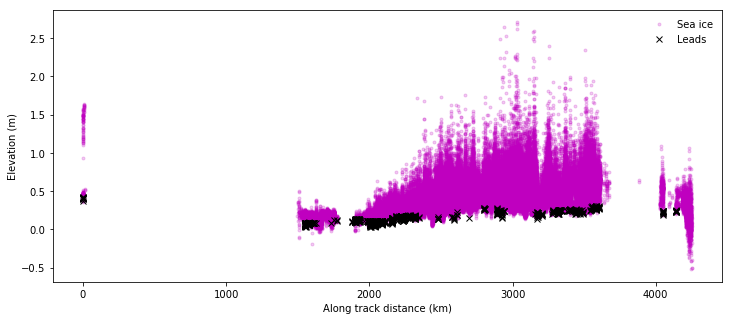

In [137]:
# 
# Note that in the ATL03 example I don't bother doing this and just keep all the data in the table and just use a condition to display data like the example commented out in the next cell..
# e.g. 
dFstype=dF07.groupby('ssh_flag')
dFstype['elev'].agg(['mean', 'std', 'median', 'mad'])
dFstypeIce=dFstype.get_group(0)
dFstypeLeads=dFstype.get_group(1)

plt.figure(figsize=(12, 5))
plt.plot((dFstypeIce.along_track_distance)/1000., dFstypeIce.elev, color='m', marker='.', linestyle='None', label='Sea ice', alpha=0.2)
plt.plot((dFstypeLeads.along_track_distance)/1000., dFstypeLeads.elev, color='k', marker='x', linestyle='None',label='Leads', alpha=1.)
plt.legend(frameon=False)
plt.xlabel('Along track distance (km)')
plt.ylabel('Elevation (m)')
plt.show()

In [138]:
# An alternative approach is to do a groupby of the above data based on the ssh_flag. 

#plt.figure(figsize=(12, 5))
#plt.plot((dF07[(dF07['ssh_flag']>0)]['along_track_distance']-dF07['along_track_distance'][0])/1000., dF07[(dF07['ssh_flag']>0)]['elev'], color='k', marker='x', linestyle='None',label='sea surface', alpha=1)
#plt.plot((dF07[(dF07['ssh_flag']==0)]['along_track_distance']-dF07['along_track_distance'][0])/1000., dF07[(dF07['ssh_flag']==0)]['elev'], color='b', marker='.', linestyle='None',label='ice', alpha=0.3)
#plt.legend(frameon=False)
#plt.xlabel('Along track distance (km)')
#plt.ylabel('Elevation (m)')
#plt.show()
dFstypeIce.head()

,elev,lons,lats,ssh_flag,quality_flag,delta_time,along_track_distance,height_segment_id,photon_rate,year,month,day,hour,second
0,0.443309,-164.275288,59.864463,0,1,2.747804e+07,0.000000,7,1.158333,2018,11,15,0,18
1,0.439604,-164.275288,59.864463,0,1,2.747804e+07,0.000000,8,2.278688,2018,11,15,0,18
2,0.469707,-164.275327,59.864671,0,1,2.747804e+07,23.241180,9,2.089552,2018,11,15,0,18
3,0.422271,-164.275374,59.864914,0,1,2.747804e+07,50.413780,10,1.769231,2018,11,15,0,18
5,0.463985,-164.275467,59.865382,0,1,2.747804e+07,102.866701,12,1.792208,2018,11,15,0,18


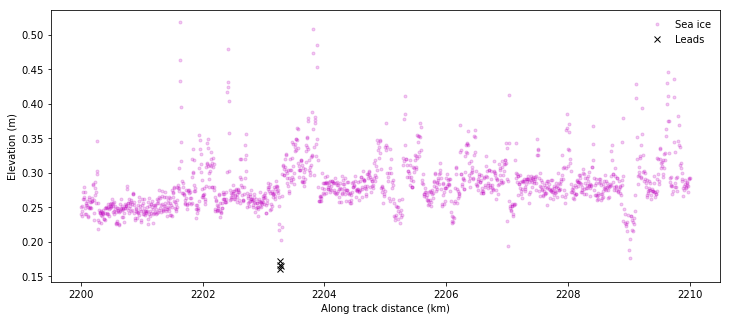

In [139]:
sectionNum=220 # 220 good, 200 surprisngly bad lead precisions
sectionSize=10000.
idx=np.where((dF07['along_track_distance']>sectionNum*sectionSize)&(dF07['along_track_distance']<(sectionNum+1)*10000.))[0]
df07S=dF07.iloc[idx]
dFStype=df07S.groupby('ssh_flag')
dFStype['elev'].agg(['mean', 'std', 'median', 'mad'])
dFStypeIce=dFStype.get_group(0)
dFStypeLeads=dFStype.get_group(1)

plt.figure(figsize=(12, 5))
plt.plot((dFStypeIce.along_track_distance)/1000., dFStypeIce.elev, color='m', marker='.', linestyle='None', label='Sea ice', alpha=0.2)
plt.plot((dFStypeLeads.along_track_distance)/1000., dFStypeLeads.elev, color='k', marker='x', linestyle='None',label='Leads', alpha=1.)
plt.legend(frameon=False)
plt.xlabel('Along track distance (km)')
plt.ylabel('Elevation (m)')
plt.show()

In [140]:
# let's take a look at the mean elevation of the sea surface (and sea ice)
# Ice elevation
meanIceElev=dFstype['elev'].get_group(0).mean()
# Sea surface elevation
meanSSH=dFstype['elev'].get_group(1).mean()
print('Sea ice elevation (m):', meanIceElev)
print('SSH (m):', meanSSH)

Sea ice elevation (m): 0.3983361
SSH (m): 0.14679515


In [141]:
# OK well now it's pretty simple to derive some freeboard!


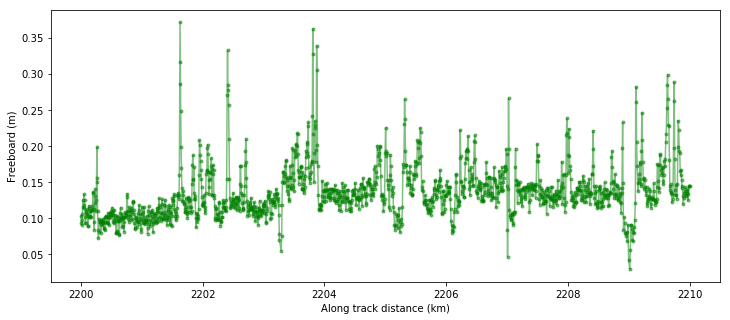

In [144]:
plt.figure(figsize=(12, 5))
plt.plot((dFStypeIce.along_track_distance)/1000., dFStypeIce.elev-meanSSH, color='g', marker='.', linestyle='-', label='Freeboard', alpha=0.5)
#plt.legend(frameon=False)
plt.xlabel('Along track distance (km)')
plt.ylabel('Freeboard (m)')
plt.show()

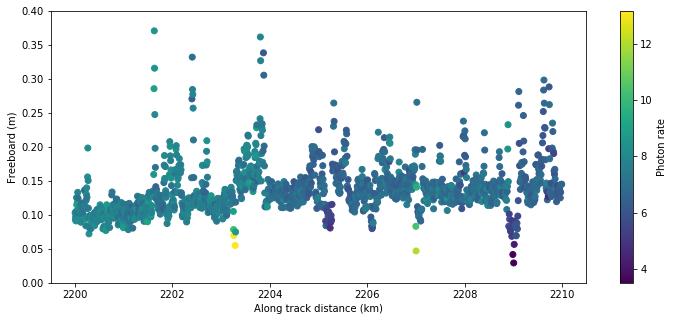

In [153]:
# Explore the photon rate
plt.figure(figsize=(12, 5))
plt.scatter((dFStypeIce.along_track_distance)/1000., dFStypeIce.elev-meanSSH, c=dFStypeIce.photon_rate, label='photon_rate')
#plt.legend(frameon=False)
plt.colorbar(label='Photon rate')
plt.xlabel('Along track distance (km)')
plt.ylabel('Freeboard (m)')
plt.show()

### Extra ideas

1. Try downloading some more ATL07 data from the NSIDC (following the hackweek tutorial) and see what it looks like. 
2. Explore the photon classification scheme (ADD WHAT VARIABLE THIS IS).
3. Explore the photon rate and background rate. How do they variable with the open water/sea ice classification? Do some scatter plots of photon rate versus ice type. 